In [1]:
import itertools
import os
import subprocess
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mplhep as hep

parent_dir = Path(os.path.abspath("RunGPUSimulation_visualization.ipynb")).parent.parent
sys.path.append(str(parent_dir))
from src.annealing_depth import plot_data_vs_sim

In [2]:
plt.style.use(hep.style.ROOT)

In [3]:
!nvidia-smi
!nvcc  -o radicals -x cu -lnvToolsExt -I ../CLI11/include ../src/solverRadicals.cu
!./radicals -h

Tue Jul 25 13:14:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB            Off| 00000000:65:00.0 Off |                    0 |
| N/A   44C    P0               28W / 250W|      0MiB / 12288MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
%%time
!./radicals --diffCoeff 0.1 --radFormRate 0.0006 --k1 0.05 --k2 0.2

Parameter                 Value
----------------------------------------
Diffusion coefficient     0.1
Radical formation rate    0.0006
Radical crosslinking rate 0.05
Radical oxidation rate    0.2
Dose rate                 1
Irradiation time          10000
Number of time steps      20000
Dimensions                (100, 100, 500)
Total number of steps     5000000
Number of slices          1000000000
Limited save              0
Output file name prefix   output
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0.59997 ms per step
CPU times: user 875 ms, sys: 248 ms, total: 1.12 s
Wall time: 43.2 s


In [5]:
activity = np.fromfile("outputactivity.dat", dtype=np.float32)
tDim = 20000
xDim = 100
yDim = 500
activity = np.reshape(activity, (tDim, yDim, xDim))

oxygen = np.fromfile("outputoxygen.dat", dtype=np.float32)
tDim = 20000
xDim = 100
yDim = 500
oxygen = np.reshape(oxygen, (tDim, yDim, xDim))

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


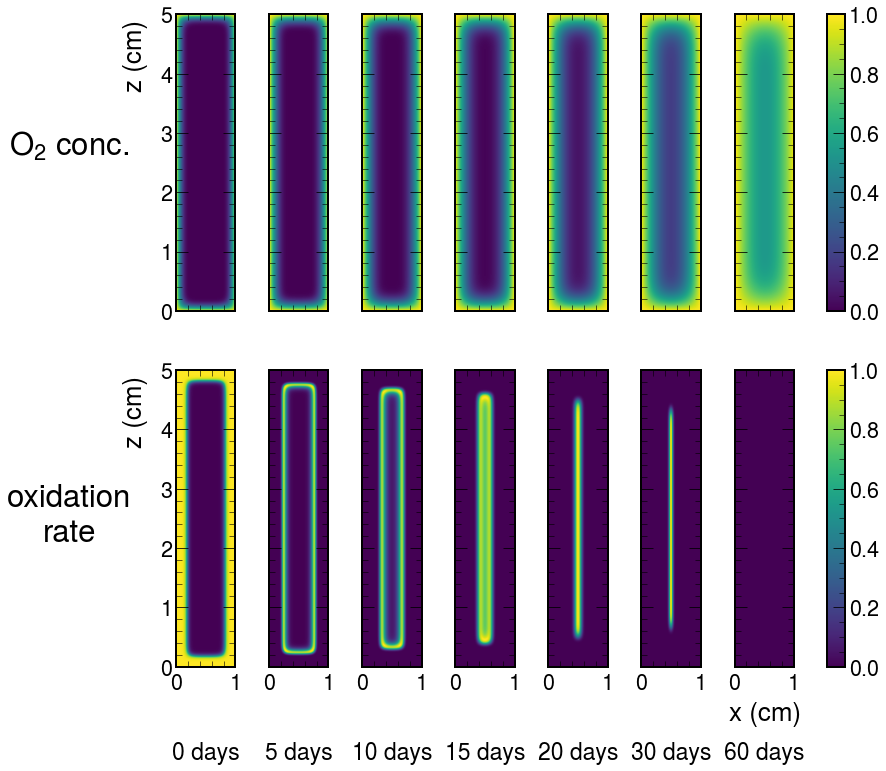

In [6]:
fig = plt.figure(figsize=(12, 12))
spec = gridspec.GridSpec(
    ncols=8, nrows=2, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 0.3], wspace=0.6
)

timesteps = [0, 500, 1000, 1500, 2000, 3000, 6000]
for i, time in enumerate(timesteps):
    ax0 = fig.add_subplot(spec[0, i])
    ax1 = fig.add_subplot(spec[1, i])
    ox_slice = oxygen[
        time + 10000,
        :,
    ]
    ac_norm = activity[time + 10000, :, :].max()
    if ac_norm > 0:
        ac_slice = activity[time + 10000, :, :] / ac_norm
    else:
        ac_slice = np.zeros_like(activity[time + 10000, :, :])
    im0 = ax0.imshow(ox_slice, vmin=0, vmax=1, extent=[0, 1, 0, 5])
    im1 = ax1.imshow(ac_slice, vmin=0, vmax=1, extent=[0, 1, 0, 5])
    ax0.set_ylim(0, 5)
    ax0.set_xlim(0, 1)
    ax1.set_ylim(0, 5)
    ax1.set_xlim(0, 1)
    if i > 0:
        ax0.tick_params(labelleft=False)
        ax1.tick_params(labelleft=False)
    ax0.tick_params(labelbottom=False)
    t_days = time / 100
    ax1.set_xlabel(f"{int(t_days)} days", size=23)
    ax1.xaxis.get_label().set_horizontalalignment("center")
    ax1.get_xaxis().set_label_coords(0.5, -0.25)
    if i == 0:
        ax0.text(-0.9, 3.8, "z (cm)", rotation="vertical")
        ax1.text(-0.9, 3.8, "z (cm)", rotation="vertical")
        ax0.set_ylabel("$O_2$ conc.", size="large")
        ax1.set_ylabel("oxidation\nrate", size="large")
        ax0.yaxis.get_label().set_horizontalalignment("center")
        ax0.get_yaxis().set_label_coords(-1.8, 0.5)
        ax0.yaxis.get_label().set_rotation(0)
        ax1.yaxis.get_label().set_horizontalalignment("center")
        ax1.get_yaxis().set_label_coords(-1.8, 0.4)
        ax1.yaxis.get_label().set_rotation(0)
    if i == 6:
        ax1.text(-0.1, -0.9, "x (cm)")
        cax0 = fig.add_subplot(spec[0, 7])
        fig.colorbar(im0, cax=cax0, orientation="vertical", pad=0.0)
        cax1 = fig.add_subplot(spec[1, 7])
        fig.colorbar(im1, cax=cax1, orientation="vertical", pad=0.0)

fig.savefig("../plots/sim_vis.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()